<a href="https://colab.research.google.com/drive/1XOHqzefoJMNmAevXZOi19BvNbBqoMMYr" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**you could see steps by steps in Colab in above ^^**

In [1]:
#from datasets import load_dataset
from typing import List, Tuple, Dict
from pprint import pprint
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [2]:
# Read corpus
def read_by_pandas(split: str) -> pd.DataFrame:
  sentences = [line.strip() for line in open(f"data/UIT-VSFC/{split}/{split}_sentences.txt").readlines()]
  labels = [int(line.strip()) for line in open(f"data/UIT-VSFC/{split}/{split}_sentiments.txt").readlines()]
  return pd.DataFrame({"sentence": sentences, "label": labels})

In [3]:
train= read_by_pandas("train")
test = read_by_pandas("test")
val = read_by_pandas("validation")

In [4]:
#Tokenizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['sentence'])
X_test = vectorizer.transform(test['sentence'])
X_val = vectorizer.transform(val['sentence'])

In [5]:
#training model
def classify(text : str):
  X_test = vectorizer.transform([text])
  pred = clf.predict(X_test)[0]
  id2label = {0: "Tiêu cực", 1: "Trung tính", 2: "Tích cực"}
  return id2label[pred]
clf = LogisticRegression(max_iter=5000).fit(X_train, train['label'])

In [6]:
classify("haha")

'Trung tính'

In [7]:
#Evaluation
y_true = np.array(test['label'].to_list())
y_pred = clf.predict(X_test)

In [8]:
# sử dụng thư viện
print("Accuracy :", accuracy_score(y_true, y_pred))
print("F1-micro :", f1_score(y_true, y_pred, average='micro'))
print("F1-macro :", f1_score(y_true, y_pred, average='macro'))
print("F1-weighted :", f1_score(y_true, y_pred, average='weighted'))

Accuracy : 0.8847125710675932
F1-micro : 0.8847125710675932
F1-macro : 0.7071943843160944
F1-weighted : 0.8759428658399829


### Matching with building from scratch

In [9]:
TP, FP, FN = {}, {}, {}
precision = {}
recall = {}
F1 = {}
N_c = {} # số lượng mẫu

In [10]:
# i = 0 (tiêu cực); i = 1 (trung tính); i = 2 (tích cực)
for i in range(3):
    # Sỗ mẫu của mỗi lớp i
    N_c[i] = (y_true == i).sum()
    # Dự đoán "lớp i" cho một mẫu, và sự thật là "lớp i" => ĐÚNG TRUE POSITIVE
    TP[i] = ((y_pred == i) & (y_pred == y_true)).sum()
    # Dự đoán "lớp i" cho một mẫu, nhưng sự thật "không phải lớp i" => SAI POSITIVE
    FP[i] = ((y_pred == i) & (y_pred != y_true)).sum()
    # Dự đoán "không phải lớp i" cho một mẫu, nhưng sự thật là "lớp i" => FALSE NEGATIVE
    FN[i] = ((y_pred != i) & (y_true == i)).sum()
    precision[i] = (TP[i]) / (TP[i] + FP[i])
    recall[i] = (TP[i]) / (TP[i] + FN[i])
    F1[i] = 2*precision[i]*recall[i] / (precision[i] + recall[i])

In [11]:
# Kết quả thực nghiệm
Accuracy = (y_true == y_pred).sum() / len(y_true) # Tổng số mẫu dự đoán đúng / Tổng số mẫu
Macro_F1 = (F1[0] + F1[1] + F1[2]) / 3
Weighted_F1 = (N_c[0] * F1[0] + N_c[1] * F1[1] + N_c[2] * F1[2]) / len(y_true)
Micro_F1 = 2*sum(TP.values()) / (2*sum(TP.values()) + sum(FP.values()) + sum(FN.values()))

In [12]:
metrics = {"Accuracy": Accuracy, "Macro_F1": Macro_F1, "Weighted_F1": Weighted_F1, "Micro_F1": Micro_F1}
for key in metrics:
    print(f"{key} {metrics[key]}")


Accuracy 0.8847125710675932
Macro_F1 0.7071943843160945
Weighted_F1 0.8759428658399832
Micro_F1 0.8847125710675932


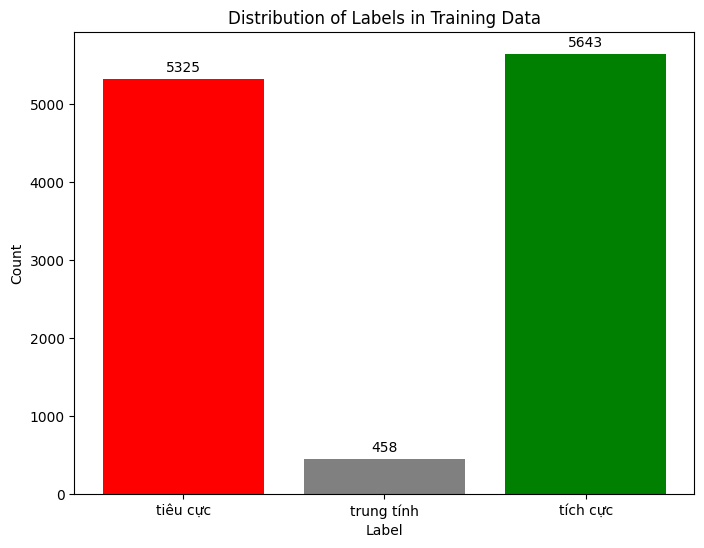

In [13]:

# Count the occurrences of each label
label_counts = train['label'].value_counts().sort_index()

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['red', 'grey', 'green'])
plt.xticks(label_counts.index, ['tiêu cực', 'trung tính', 'tích cực'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')

# Add the count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom') # Adjust the vertical offset (50) as needed

plt.show()

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the labels
labels = ["Negative", "Neutral", "Positive"]

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create the heatmap using Plotly Express
fig = px.imshow(cm_df, text_auto=True, aspect="equal",
                color_continuous_scale="Viridis",
                labels=dict(x="Predicted", y="True", color="Count"),
                title="Confusion Matrix")

# Update layout for better readability
fig.update_layout(
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)

# Save the figure as an HTML file
fig.write_html("confusion_matrix.html")

fig.show()